### LangGraph Basic

State 정의

In [2]:
from typing import TypedDict, Annotated, List
from langchain_core.documents import Document
import operator

# State 정의 
class GraphState(TypedDict):
    context: Annotated[List[Document], operator.add]
    answer: Annotated[List[Document], operator.add]
    question: Annotated[str, "user question"]
    sql_query: Annotated[str, "sql query"]
    binary_score: Annotated[str, "binary score yes or no"]

Node 정의

In [5]:
# retrieve: 검색
def retrieve(state: GraphState) -> GraphState:
    documents = "검색된 문서"
    return {"context": documents}

# Query Transform: 쿼리 재작성
def rewrite_query(state: GraphState) -> GraphState:
    documents = "검색된 문서"
    return GraphState(context=documents)

# LLM 실행
def llm_gpt_execute(state: GraphState) -> GraphState:
    answer = "GPT 답변"
    return GraphState(answer=answer)

# LLM 실행
def llm_claude_execute(state: GraphState) -> GraphState:
    answer = "Claude 답변"
    return GraphState(answer=answer)

# Relevance Check: 관련성 확인
def relevance_check(state: GraphState) -> GraphState:
    binary_score = "Revalance Score"
    return GraphState(binary_score=binary_score)

# sum_up: 결과 종합
def sum_up(state: GraphState) -> GraphState:
    answer = "종합된 답변"
    return GraphState(answer=answer)

# Search on Web : 웹 검색
def search_on_web(state: GraphState) -> GraphState:
    documents = state["context"] = "기존 문서"
    searched_documents = "검색된 문서"
    documents += searched_documents
    return GraphState(context=documents)

# Get Table Info: 테이블 정보 가져오기
def get_table_info(state: GraphState) -> GraphState:
    table_info = "테이블 정보"
    return GraphState(context=table_info)

# Make SQL Query: SQL 쿼리 생성
def generate_sql_query(state: GraphState) -> GraphState:
    sql_query = "SQL 쿼리"
    return GraphState(sql_query=sql_query)

# Execute SQL Query: SQL 쿼리 실행
def execute_sql_query(state: GraphState) -> GraphState:
    sql_result = "SQL  실행 결과"
    return GraphState(context=sql_result)
    
# Validate SQL Query: SQL 쿼리 검증
def validate_sql_query(state: GraphState) -> GraphState:
    binary_score = "SQL 쿼리 검증 결과"
    return GraphState(binary_score=binary_score)

# Error Handing: 에러 처리 
def handle_error(state: GraphState) -> GraphState:
    error = "에러 발생"
    return GraphState(context=error)

# 의사결정
def decision(state: GraphState) -> GraphState:
    decision = "결정"
    
    if state["binary_score"] == "yes":
        return "종료"
    else:
        return "재검색"

그래프 정의

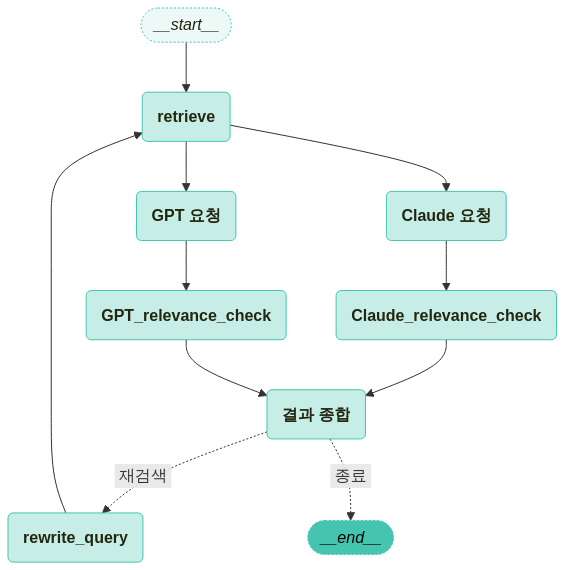

In [11]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_teddynote.graphs import visualize_graph

# 1. Conventional RAG
# 2. 재검색
# 3. 멀티 LLM 
# 4. 쿼리 재작성 

workflow = StateGraph(GraphState)

# 노드 추가
workflow.add_node("retrieve", retrieve)
workflow.add_node("rewrite_query", rewrite_query)

workflow.add_node("GPT 요청", llm_gpt_execute)
workflow.add_node("Claude 요청", llm_claude_execute)

workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("Claude_relevance_check", relevance_check)

workflow.add_node("결과 종합", sum_up)

# 엣지로 연결
workflow.add_edge("retrieve", "GPT 요청")
workflow.add_edge("retrieve", "Claude 요청")
workflow.add_edge("rewrite_query", "retrieve")
workflow.add_edge("GPT 요청", "GPT_relevance_check")
workflow.add_edge("GPT_relevance_check", "결과 종합")
workflow.add_edge("Claude 요청", "Claude_relevance_check")
workflow.add_edge("Claude_relevance_check", "결과 종합")

# 조건 처리 및 종료
# workflow.add_edge("결과 종합", END)
# workflow.add_conditional_edges(
#     "결과 종합",
#     decision, 
#     {
#         "재검색": "retrieve",
#         "종료": END
#     }
# )
workflow.add_conditional_edges(
    "결과 종합",
    decision, 
    {
        "재검색": "rewrite_query",
        "종료": END
    }
)

# 시작점
workflow.set_entry_point("retrieve")

# 메모리 
memory = MemorySaver()

# 그래프 컴파일 
app = workflow.compile(checkpointer=memory)

# 시각화
visualize_graph(app)